# Visualize evaluation results

First you need to run the evaluation pipeline to obtain the score JSONs. Then you can use this notebook to visualize the results.

In [42]:
# just imports
import json
from pathlib import Path

from matplotlib import pyplot as plt


In [12]:
# define paths to score files (and give nicknames for easier comparison)
score_files = {
    "gt_comparison": "/home/hdd/data/greatesthits/evaluation/GT_subset/scores_2023-12-11T13-56-46.json",
    "frozen_v1": "/home/hdd/data/greatesthits/evaluation/23-11-27T09-53-32/generated_samples_23-12-01T15-41-49_subset/scores_2023-12-11T13-15-08.json",
    "torch_def_v1": "/home/hdd/data/greatesthits/evaluation/23-11-27T10-08-43/generated_samples_23-12-01T17-17-59_subset/scores_2023-12-11T13-23-45.json",
    "mst_def_v1": "/home/hdd/data/greatesthits/evaluation/23-12-01T10-23-26/generated_samples_23-12-04T09-46-37_subset/scores_2023-12-11T13-28-44.json",
    "torch_def_v2": "/home/hdd/data/greatesthits/evaluation/23-12-05T11-46-10/generated_samples_23-12-07T09-44-53/scores_2023-12-11T13-36-57.json",
    "frozen_v2": "/home/hdd/data/greatesthits/evaluation/23-12-05T11-49-31/generated_samples_23-12-07T09-58-20/scores_2023-12-11T13-39-47.json",
    "mst_def_v2": "/home/hdd/data/greatesthits/evaluation/23-12-05T11-55-04/generated_samples_23-12-10T20-33-08/scores_2023-12-11T13-42-42.json",
}


In [13]:
# read scores from files
scores = {}
for name, path in score_files.items():
    with open(path, "r") as f:
        scores[name] = json.load(f)


## Frechet Audio Distance (FAD)

The FAD is a metric to evaluate the quality of generated audio. It is based on the Frechet Inception Distance (FID) metric for images. The FAD is computed by comparing the statistics of the activations of a pretrained network (VGGIsh/InceptionV3/etc.) for the generated and real audio. The FAD is a scalar value, where **lower values indicate better quality**.

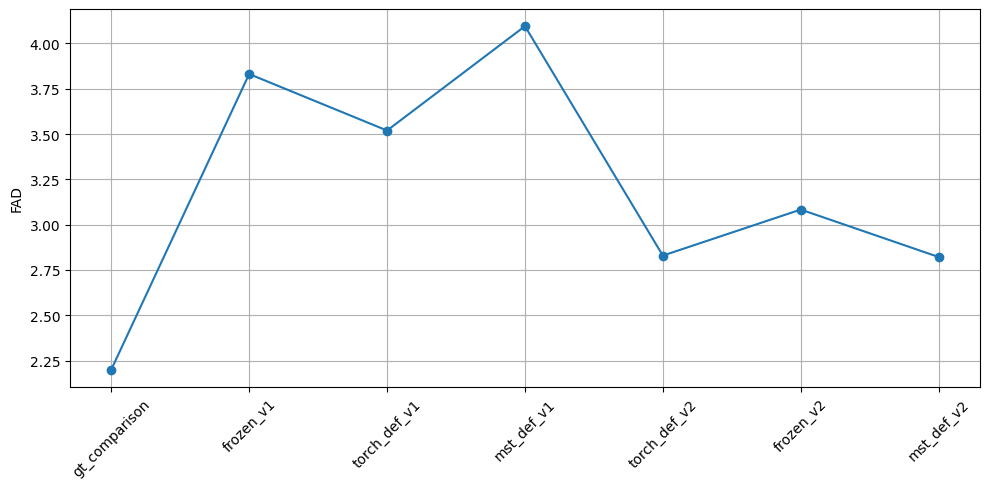

In [27]:
fad_index = 1
fad_key = "FAD"
fad_scores_per_test = [(scores[name][fad_index][fad_key], name) for name in score_files.keys()]
fad_scores, names = zip(*fad_scores_per_test)

plt.figure(figsize=(10, 5))
plt.plot(names, fad_scores, "-o")
plt.ylabel("FAD")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()


# Kulback-Leibler Divergence (KLD)
The KLD is a metric to evaluate the quality of generated audio. It is based on the Kulback-Leibler Divergence (KLD) metric for images. The KLD is computed by comparing the statistics of the activations of a pretrained PaSST classifier for the generated and real audio. The KLD is a scalar value, where **lower values indicate better quality**.

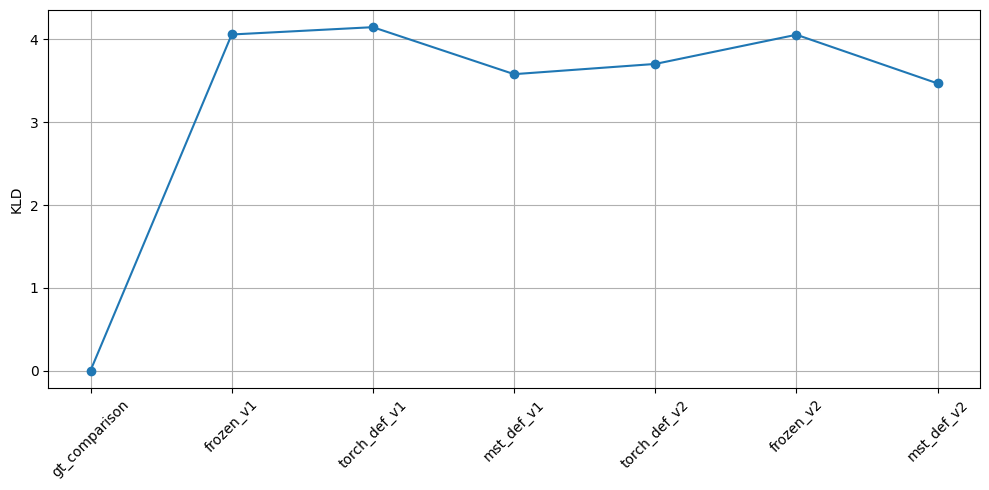

In [26]:
kld_index = 2
kld_main_key = "KLD"
kld_kld_key = "kld"
kld_pq_key = "kld_pq"
kld_qp_key = "kld_qp"
kld_both_key = "kld_both"
kld_scores_per_test = [
    (
        scores[name][kld_index][kld_main_key][kld_kld_key],
        scores[name][kld_index][kld_main_key][kld_pq_key],
        scores[name][kld_index][kld_main_key][kld_qp_key],
        scores[name][kld_index][kld_main_key][kld_both_key],
        name,
    )
    for name in score_files.keys()
]
kld, kld_pq, kld_qp, kld_both, names = zip(*kld_scores_per_test)

plt.figure(figsize=(10, 5))
plt.plot(names, kld, "-o")
plt.ylabel("KLD")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()


# Cross Correlation Lags (CCL)

The CCL is a metric based on simple cross correlation between generated and real audio. It is computed by finding the lag that maximizes the cross correlation between the generated and real audio. The CCL is a scalar value, where **lower values indicate better quality**.

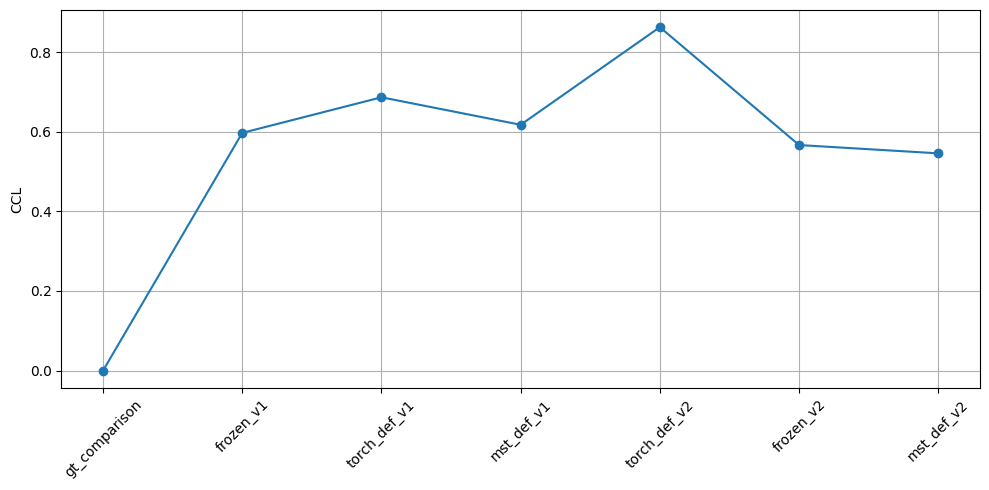

In [29]:
xcorr_index = 3
xcorr_key = "XCORR"
xcorr_scores_per_test = [(scores[name][xcorr_index][xcorr_key], name) for name in score_files.keys()]
xcorr_scores, names = zip(*xcorr_scores_per_test)

plt.figure(figsize=(10, 5))
plt.plot(names, xcorr_scores, "-o")
plt.ylabel("CCL")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()


# Latency
Latency evaluates the altency of audio signal based on visual ques. It is computed with a SparseSync classifier. Model classifies each video to one of the following classes [-2.0, -1.8, ..., 0.0, ..., 1.8, 2.0], where 0.0 implifies that the signals are in sync. Larger the bubble higher the probability of the class. 

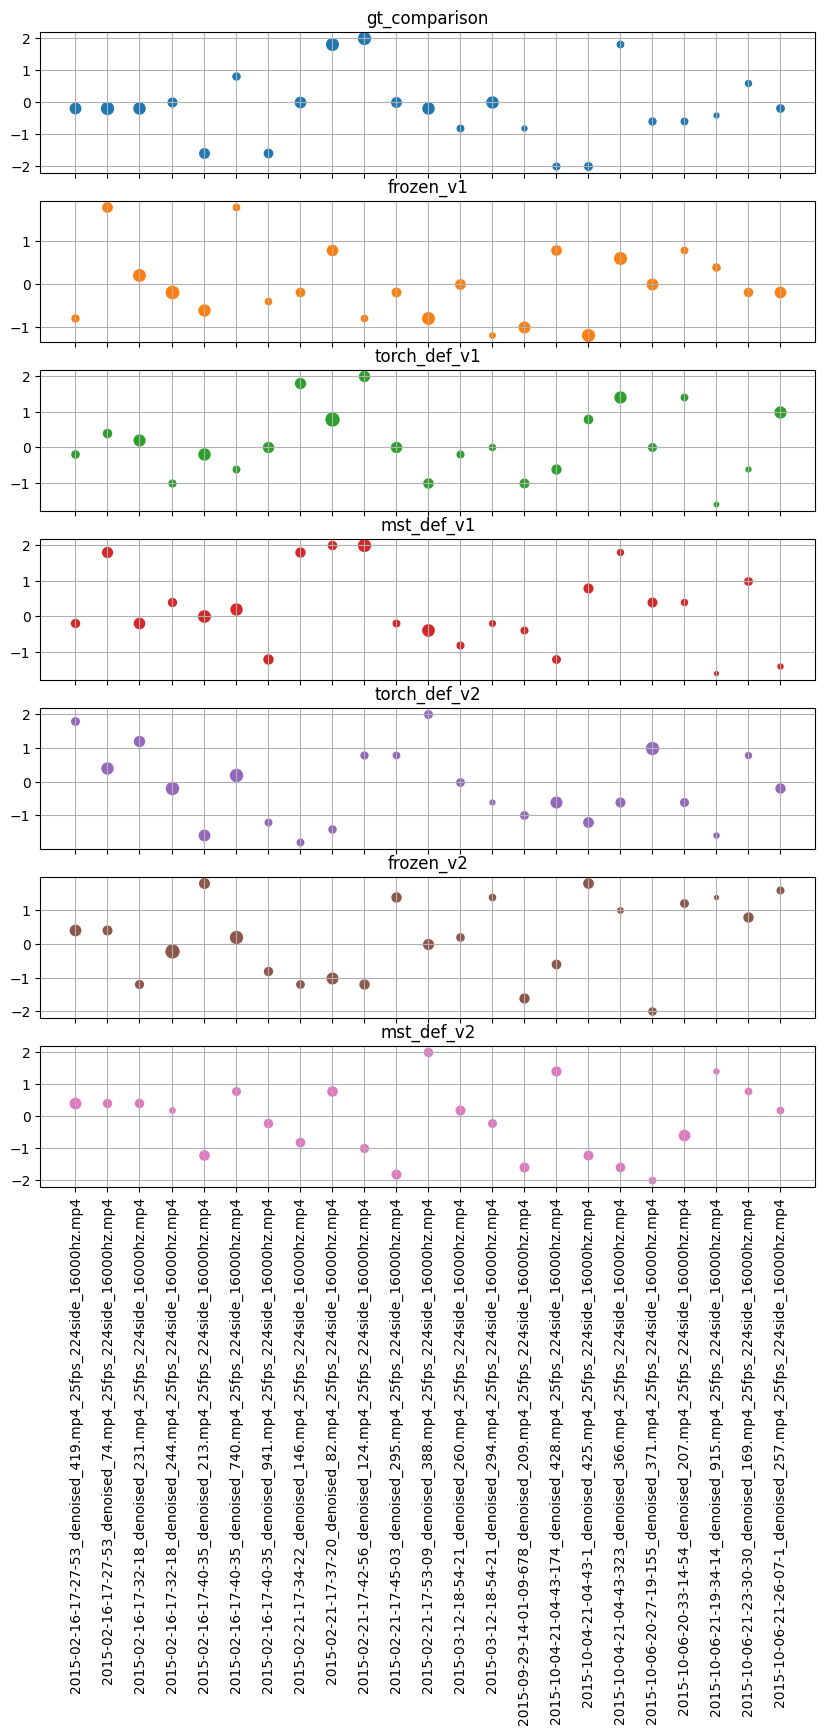

In [55]:
latency_index = 4
latency_key = "LATENCY"

fig, axs = plt.subplots(len(scores), figsize=(10, 15), sharex=True)
plt.xticks(rotation=90)
i = 0
for name, metrics in scores.items():
    latency_metrics = dict(sorted(metrics[latency_index][latency_key].items(), key=lambda p: Path(p[0]).name))
    for file, latency_score in latency_metrics.items():
        axs[i].scatter(Path(file).name, latency_score["class"], s=latency_score["prob"]*100, color=f"C{i}")
        axs[i].set_title(name)
        axs[i].grid()
    i += 1
